In [1]:
"""
SEQUENCE-TO-SEQUENCE (SEQ2SEQ) - APLICACIONES AVANZADAS
=======================================================

Objetivos:
- Aprender ejemplos de aplicaciones para datos de secuencia
- Implementar traducción automática con LSTM Seq2Seq
- Experimentar con image captioning usando modelos preentrenados
- Comprender tokenización a nivel de carácter
- Migrar entre PyTorch y Keras
- Investigar técnicas avanzadas de traducción

Sprint: Seq2Seq Applications
Framework: TensorFlow/Keras y PyTorch
Aplicaciones: Machine Translation, Image Captioning
Técnicas: Character-level tokenization, Attention mechanisms
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import os
import re
import string
import pickle
from collections import Counter

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, TimeDistributed,
    Attention, AdditiveAttention, MultiHeadAttention
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn para tokenización
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Image processing
from PIL import Image
import requests
from io import BytesIO

# Configuración de estilo
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("whitegrid")

print("="*80)
print("SEQUENCE-TO-SEQUENCE (SEQ2SEQ) - APLICACIONES AVANZADAS")
print("Traducción automática e Image Captioning")
print("="*80)

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Información de versiones
print(f"\n🔧 CONFIGURACIÓN DEL ENTORNO:")
print(f"   • TensorFlow: {tf.__version__}")
print(f"   • Keras: {keras.__version__}")
print(f"   • NumPy: {np.__version__}")
print(f"   • GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

print(f"\n💡 CONCEPTOS FUNDAMENTALES DE SEQ2SEQ:")
seq2seq_concepts = """
🔄 SEQUENCE-TO-SEQUENCE (SEQ2SEQ):

🏗️ ARQUITECTURA ENCODER-DECODER:
• Encoder: Procesa secuencia de entrada y genera representación
• Context Vector: Representación compacta de la información
• Decoder: Genera secuencia de salida paso a paso

⚡ COMPONENTES CLAVE:
• Teacher Forcing: Usar ground truth durante entrenamiento
• Inference: Generar secuencia usando predicciones previas
• Attention: Mecanismo para enfocar partes relevantes del input

🎯 APLICACIONES PRINCIPALES:
• Machine Translation (inglés ↔ francés, español, etc.)
• Text Summarization (documento → resumen)
• Image Captioning (imagen → descripción)
• Chatbots (pregunta → respuesta)
• Code Generation (descripción → código)

🔤 TOKENIZACIÓN:
• Word-level: Tokens son palabras completas
• Character-level: Tokens son caracteres individuales
• Subword: BPE, SentencePiece (balance entre word y char)
"""

print(seq2seq_concepts)


SEQUENCE-TO-SEQUENCE (SEQ2SEQ) - APLICACIONES AVANZADAS
Traducción automática e Image Captioning

🔧 CONFIGURACIÓN DEL ENTORNO:
   • TensorFlow: 2.13.0


AttributeError: module 'keras.api._v2.keras' has no attribute '__version__'


🌍 1. TRADUCCIÓN AUTOMÁTICA - IMPLEMENTACIÓN SEQ2SEQ
📚 PREPARANDO DATOS PARA TRADUCCIÓN INGLÉS-FRANCÉS:
✅ Dataset de traducción creado:
   • Pares de frases: 20
   • Ejemplo EN: 'Hello, how are you?'
   • Ejemplo FR: 'Bonjour, comment allez-vous?'

📊 ANÁLISIS DEL DATASET:
   • Longitud promedio EN: 4.0 palabras
   • Longitud promedio FR: 3.0 palabras
   • Max longitud EN: 5 palabras
   • Max longitud FR: 5 palabras

🔧 PREPROCESAMIENTO COMPLETADO:
   • Ejemplo EN procesado: '<start> hello, how are you? <end>'
   • Ejemplo FR procesado: '<start> bonjour, comment allezvous? <end>'


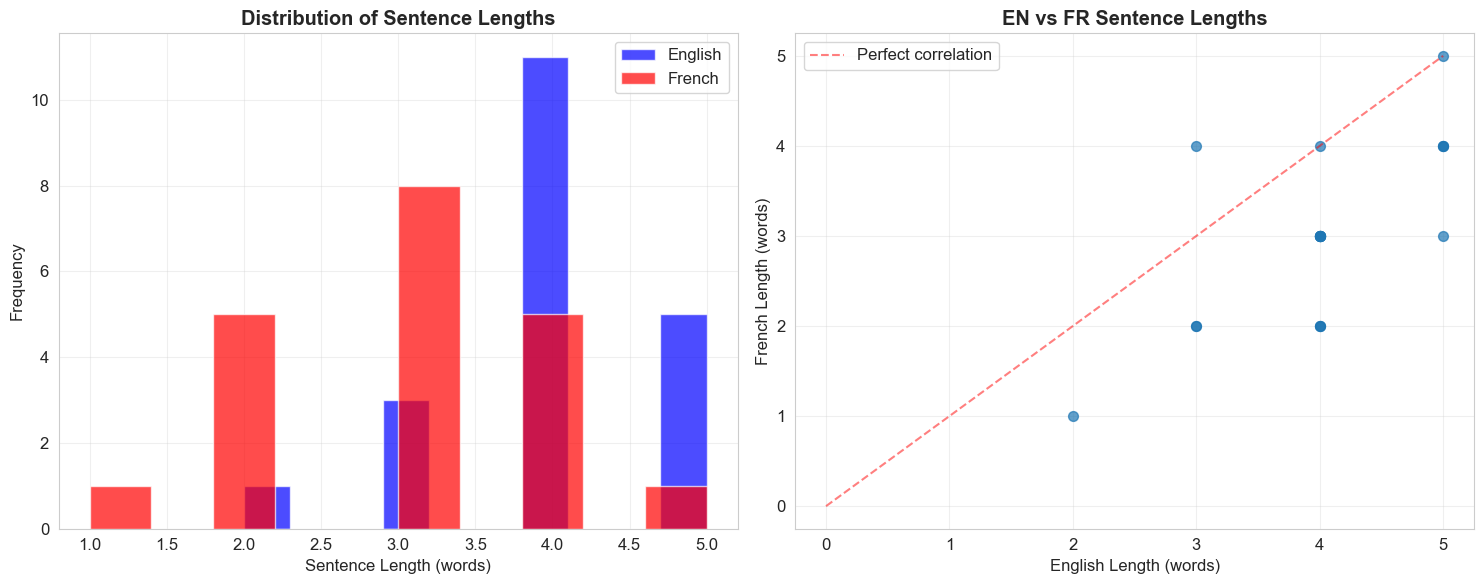

✅ Análisis de datos completado


In [2]:
# ============================================================================
# 1. TRADUCCIÓN AUTOMÁTICA - IMPLEMENTACIÓN SEQ2SEQ
# ============================================================================

print("\n🌍 1. TRADUCCIÓN AUTOMÁTICA - IMPLEMENTACIÓN SEQ2SEQ")
print("="*55)

print("📚 PREPARANDO DATOS PARA TRADUCCIÓN INGLÉS-FRANCÉS:")

def create_translation_dataset():
    """
    Crear un dataset sintético para traducción inglés-francés
    (En producción se usarían datasets como WMT, OPUS, etc.)
    """
    
    # Dataset sintético pequeño para demostración
    english_sentences = [
        "Hello, how are you?",
        "What is your name?", 
        "I love machine learning.",
        "The weather is nice today.",
        "Where are you from?",
        "I am learning deep learning.",
        "This is a beautiful day.",
        "Can you help me?",
        "I want to learn French.",
        "Thank you very much.",
        "Good morning!",
        "How old are you?",
        "I like to read books.",
        "What time is it?",
        "See you later.",
        "I am hungry.",
        "The cat is sleeping.",
        "It is raining outside.",
        "I have a question.",
        "Goodbye, my friend."
    ]
    
    french_sentences = [
        "Bonjour, comment allez-vous?",
        "Quel est votre nom?",
        "J'adore l'apprentissage automatique.",
        "Il fait beau aujourd'hui.",
        "D'où venez-vous?",
        "J'apprends l'apprentissage profond.",
        "C'est une belle journée.",
        "Pouvez-vous m'aider?",
        "Je veux apprendre le français.",
        "Merci beaucoup.",
        "Bonjour!",
        "Quel âge avez-vous?",
        "J'aime lire des livres.",
        "Quelle heure est-il?",
        "À bientôt.",
        "J'ai faim.",
        "Le chat dort.",
        "Il pleut dehors.",
        "J'ai une question.",
        "Au revoir, mon ami."
    ]
    
    return english_sentences, french_sentences

# Cargar datos
english_texts, french_texts = create_translation_dataset()

print(f"✅ Dataset de traducción creado:")
print(f"   • Pares de frases: {len(english_texts)}")
print(f"   • Ejemplo EN: '{english_texts[0]}'")
print(f"   • Ejemplo FR: '{french_texts[0]}'")

# Análisis de características del dataset
print(f"\n📊 ANÁLISIS DEL DATASET:")

# Longitudes de secuencias
en_lengths = [len(text.split()) for text in english_texts]
fr_lengths = [len(text.split()) for text in french_texts]

print(f"   • Longitud promedio EN: {np.mean(en_lengths):.1f} palabras")
print(f"   • Longitud promedio FR: {np.mean(fr_lengths):.1f} palabras")
print(f"   • Max longitud EN: {max(en_lengths)} palabras")
print(f"   • Max longitud FR: {max(fr_lengths)} palabras")

# Preprocesamiento de texto
def preprocess_text(texts):
    """
    Preprocesar textos para traducción
    """
    processed = []
    for text in texts:
        # Convertir a minúsculas
        text = text.lower()
        # Remover puntuación extra (mantener básica)
        text = re.sub(r'[^\w\s\.\?\!,]', '', text)
        # Agregar tokens especiales
        text = '<start> ' + text + ' <end>'
        processed.append(text)
    
    return processed

# Preprocesar textos
english_processed = preprocess_text(english_texts)
french_processed = preprocess_text(french_texts)

print(f"\n🔧 PREPROCESAMIENTO COMPLETADO:")
print(f"   • Ejemplo EN procesado: '{english_processed[0]}'")
print(f"   • Ejemplo FR procesado: '{french_processed[0]}'")

# Visualización de distribución de longitudes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(en_lengths, bins=10, alpha=0.7, color='blue', label='English')
axes[0].hist(fr_lengths, bins=10, alpha=0.7, color='red', label='French')
axes[0].set_xlabel('Sentence Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentence Lengths', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Comparación de longitudes EN vs FR
axes[1].scatter(en_lengths, fr_lengths, alpha=0.7, s=50)
axes[1].plot([0, max(max(en_lengths), max(fr_lengths))], 
             [0, max(max(en_lengths), max(fr_lengths))], 
             'r--', alpha=0.5, label='Perfect correlation')
axes[1].set_xlabel('English Length (words)')
axes[1].set_ylabel('French Length (words)')
axes[1].set_title('EN vs FR Sentence Lengths', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Análisis de datos completado")


In [3]:
# ============================================================================
# 2. TOKENIZACIÓN A NIVEL DE CARÁCTER
# ============================================================================

print("\n🔤 2. TOKENIZACIÓN A NIVEL DE CARÁCTER")
print("="*40)

print("🔍 COMPARANDO TOKENIZACIÓN WORD-LEVEL vs CHARACTER-LEVEL:")

def demonstrate_tokenization_methods(texts, max_examples=3):
    """
    Demostrar diferentes métodos de tokenización
    """
    
    print(f"📝 EJEMPLOS DE TOKENIZACIÓN:")
    
    for i, text in enumerate(texts[:max_examples]):
        print(f"\n   Texto {i+1}: '{text}'")
        
        # Word-level tokenization
        word_tokens = text.split()
        print(f"   Word-level: {word_tokens}")
        
        # Character-level tokenization  
        char_tokens = list(text.replace(' ', '<space>'))
        print(f"   Char-level: {char_tokens}")
        
        # Character-level with word boundaries (char_wb simulation)
        char_wb_tokens = []
        words = text.split()
        for word in words:
            char_wb_tokens.extend(list(word))
            char_wb_tokens.append('<space>')
        char_wb_tokens = char_wb_tokens[:-1]  # Remove last space
        print(f"   Char_wb-like: {char_wb_tokens}")

# Demostrar con algunas frases
demonstrate_tokenization_methods(english_processed)

# Implementar tokenización usando CountVectorizer
print(f"\n🛠️ IMPLEMENTACIÓN CON CountVectorizer:")

# Word-level
word_vectorizer = CountVectorizer(analyzer='word', max_features=1000)
word_matrix = word_vectorizer.fit_transform(english_processed + french_processed)

# Character-level
char_vectorizer = CountVectorizer(analyzer='char', max_features=1000)
char_matrix = char_vectorizer.fit_transform(english_processed + french_processed)

# Character n-grams
char_wb_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,3), max_features=1000)
char_wb_matrix = char_wb_vectorizer.fit_transform(english_processed + french_processed)

print(f"✅ RESULTADOS DE VECTORIZACIÓN:")
print(f"   • Word-level vocabulary: {len(word_vectorizer.vocabulary_)} tokens")
print(f"   • Char-level vocabulary: {len(char_vectorizer.vocabulary_)} tokens")
print(f"   • Char_wb n-grams: {len(char_wb_vectorizer.vocabulary_)} tokens")

# Mostrar ejemplos de vocabularios
print(f"\n📚 EJEMPLOS DE VOCABULARIOS:")

print(f"   Word-level (primeros 10): {list(word_vectorizer.vocabulary_.keys())[:10]}")
print(f"   Char-level (primeros 10): {list(char_vectorizer.vocabulary_.keys())[:10]}")
print(f"   Char_wb (primeros 10): {list(char_wb_vectorizer.vocabulary_.keys())[:10]}")

# Análisis de ventajas/desventajas
print(f"\n⚖️ ANÁLISIS COMPARATIVO DE TOKENIZACIÓN:")

tokenization_comparison = {
    'Word-level': {
        'Ventajas': [
            'Preserva significado semántico',
            'Vocabulario más pequeño',
            'Procesamiento más rápido',
            'Mejor para idiomas con espacios claros'
        ],
        'Desventajas': [
            'Problema de OOV (Out of Vocabulary)',
            'No maneja morfología compleja',
            'Requiere preprocessing extensivo',
            'Mal para idiomas aglutinantes'
        ],
        'Uso recomendado': 'NLP general, idiomas como inglés/francés'
    },
    
    'Character-level': {
        'Ventajas': [
            'Sin problema de OOV',
            'Maneja morfología automáticamente',
            'Funciona para cualquier idioma',
            'Robusta con typos y ruido'
        ],
        'Desventajas': [
            'Secuencias muy largas',
            'Pierde información semántica',
            'Entrenamiento más lento',
            'Requiere más memoria'
        ],
        'Uso recomendado': 'Idiomas morfológicamente complejos, datos con ruido'
    }
}

for method, analysis in tokenization_comparison.items():
    print(f"\n   🔧 {method.upper()}:")
    print(f"      ✅ Ventajas:")
    for ventaja in analysis['Ventajas']:
        print(f"         • {ventaja}")
    print(f"      ⚠️ Desventajas:")
    for desventaja in analysis['Desventajas']:
        print(f"         • {desventaja}")
    print(f"      🎯 Uso recomendado: {analysis['Uso recomendado']}")

print("✅ Análisis de tokenización completado")



🔤 2. TOKENIZACIÓN A NIVEL DE CARÁCTER
🔍 COMPARANDO TOKENIZACIÓN WORD-LEVEL vs CHARACTER-LEVEL:
📝 EJEMPLOS DE TOKENIZACIÓN:

   Texto 1: '<start> hello, how are you? <end>'
   Word-level: ['<start>', 'hello,', 'how', 'are', 'you?', '<end>']
   Char-level: ['<', 's', 't', 'a', 'r', 't', '>', '<', 's', 'p', 'a', 'c', 'e', '>', 'h', 'e', 'l', 'l', 'o', ',', '<', 's', 'p', 'a', 'c', 'e', '>', 'h', 'o', 'w', '<', 's', 'p', 'a', 'c', 'e', '>', 'a', 'r', 'e', '<', 's', 'p', 'a', 'c', 'e', '>', 'y', 'o', 'u', '?', '<', 's', 'p', 'a', 'c', 'e', '>', '<', 'e', 'n', 'd', '>']
   Char_wb-like: ['<', 's', 't', 'a', 'r', 't', '>', '<space>', 'h', 'e', 'l', 'l', 'o', ',', '<space>', 'h', 'o', 'w', '<space>', 'a', 'r', 'e', '<space>', 'y', 'o', 'u', '?', '<space>', '<', 'e', 'n', 'd', '>']

   Texto 2: '<start> what is your name? <end>'
   Word-level: ['<start>', 'what', 'is', 'your', 'name?', '<end>']
   Char-level: ['<', 's', 't', 'a', 'r', 't', '>', '<', 's', 'p', 'a', 'c', 'e', '>', 'w', 'h', 'a',


🏗️ 3. IMPLEMENTACIÓN SEQ2SEQ PARA TRADUCCIÓN
🔧 CREANDO TOKENIZADORES PARA ENCODER Y DECODER:
✅ TOKENIZADORES CREADOS:
   • Vocabulario inglés: 60 tokens
   • Vocabulario francés: 57 tokens
   • Max longitud encoder: 7
   • Max longitud decoder: 7
   • Encoder input shape: (20, 7)
   • Decoder input shape: (20, 7)
   • Decoder target shape: (20, 7)

🏗️ CONSTRUYENDO MODELO SEQ2SEQ:
✅ Modelo Seq2Seq creado:
   • Parámetros totales: 285,497
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 7)]                  0         []                            
                                                

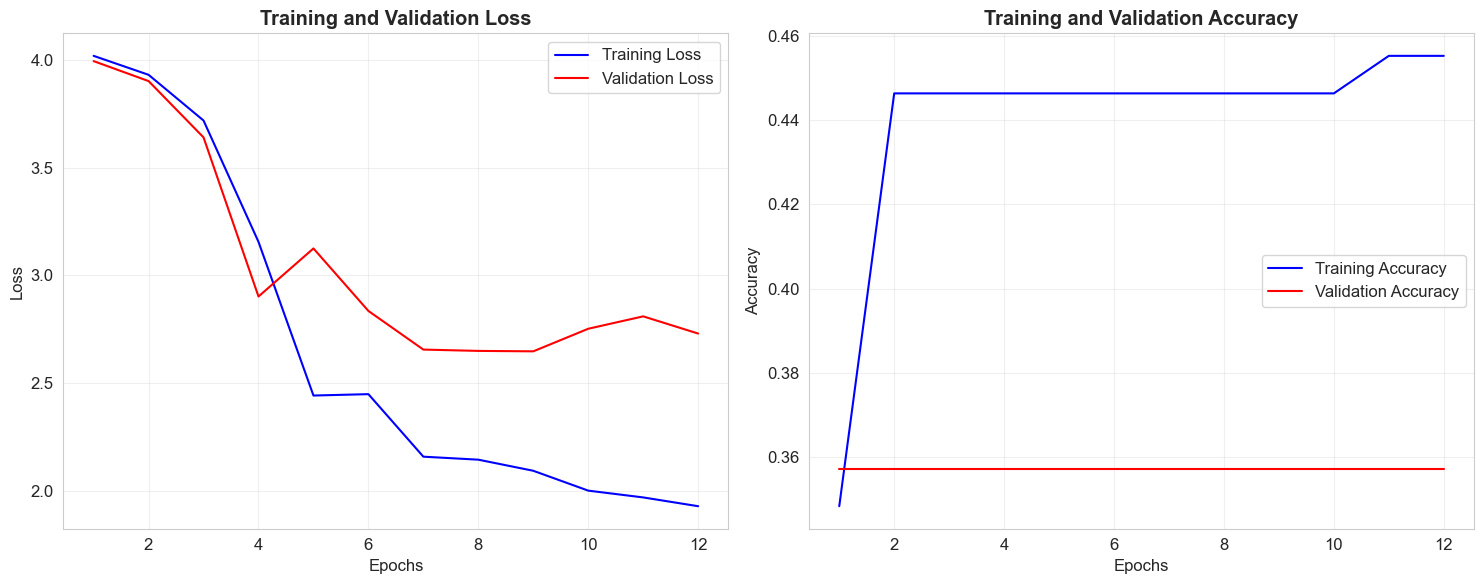

✅ Modelo Seq2Seq implementado


In [4]:
# ============================================================================
# 3. IMPLEMENTACIÓN SEQ2SEQ PARA TRADUCCIÓN
# ============================================================================

print("\n🏗️ 3. IMPLEMENTACIÓN SEQ2SEQ PARA TRADUCCIÓN")
print("="*50)

print("🔧 CREANDO TOKENIZADORES PARA ENCODER Y DECODER:")

# Crear tokenizadores usando Keras Tokenizer
def create_tokenizers(input_texts, target_texts):
    """
    Crear tokenizadores para input y target
    """
    
    # Tokenizer para input (inglés)
    input_tokenizer = Tokenizer(char_level=False, filters='')
    input_tokenizer.fit_on_texts(input_texts)
    
    # Tokenizer para target (francés)
    target_tokenizer = Tokenizer(char_level=False, filters='')
    target_tokenizer.fit_on_texts(target_texts)
    
    return input_tokenizer, target_tokenizer

# Crear tokenizadores
input_tokenizer, target_tokenizer = create_tokenizers(english_processed, french_processed)

# Información de vocabularios
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print(f"✅ TOKENIZADORES CREADOS:")
print(f"   • Vocabulario inglés: {input_vocab_size} tokens")
print(f"   • Vocabulario francés: {target_vocab_size} tokens")

# Convertir textos a secuencias
input_sequences = input_tokenizer.texts_to_sequences(english_processed)
target_sequences = target_tokenizer.texts_to_sequences(french_processed)

# Encontrar longitud máxima
max_encoder_seq_length = max(len(seq) for seq in input_sequences)
max_decoder_seq_length = max(len(seq) for seq in target_sequences)

print(f"   • Max longitud encoder: {max_encoder_seq_length}")
print(f"   • Max longitud decoder: {max_decoder_seq_length}")

# Padding de secuencias
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

# Crear decoder targets (desplazados por un paso)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

print(f"   • Encoder input shape: {encoder_input_data.shape}")
print(f"   • Decoder input shape: {decoder_input_data.shape}")
print(f"   • Decoder target shape: {decoder_target_data.shape}")

# Modelo Seq2Seq básico
print(f"\n🏗️ CONSTRUYENDO MODELO SEQ2SEQ:")

def create_seq2seq_model(input_vocab_size, target_vocab_size, 
                        max_encoder_seq_length, max_decoder_seq_length,
                        latent_dim=256):
    """
    Crear modelo Seq2Seq básico con LSTM
    """
    
    # Encoder
    encoder_inputs = Input(shape=(max_encoder_seq_length,))
    encoder_embedding = Embedding(input_vocab_size, latent_dim)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_inputs = Input(shape=(max_decoder_seq_length,))
    decoder_embedding = Embedding(target_vocab_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    # Dense layer para generar vocabulario de salida
    decoder_dense = Dense(target_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Modelo completo
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model, encoder_inputs, decoder_inputs, decoder_dense, encoder_states

# Crear modelo
seq2seq_model, encoder_inputs, decoder_inputs, decoder_dense, encoder_states = create_seq2seq_model(
    input_vocab_size, target_vocab_size, 
    max_encoder_seq_length, max_decoder_seq_length,
    latent_dim=128
)

# Compilar modelo
seq2seq_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Modelo Seq2Seq creado:")
print(f"   • Parámetros totales: {seq2seq_model.count_params():,}")

# Mostrar arquitectura
seq2seq_model.summary()

# Entrenar modelo (épocas reducidas para demostración)
print(f"\n🏋️ ENTRENANDO MODELO SEQ2SEQ:")

try:
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('seq2seq_best.h5', save_best_only=True)
    ]
    
    # Split datos para validación
    val_split = 0.2
    n_val = int(len(encoder_input_data) * val_split)
    
    train_encoder = encoder_input_data[n_val:]
    train_decoder_input = decoder_input_data[n_val:]
    train_decoder_target = decoder_target_data[n_val:]
    
    val_encoder = encoder_input_data[:n_val]
    val_decoder_input = decoder_input_data[:n_val]
    val_decoder_target = decoder_target_data[:n_val]
    
    print(f"   • Training samples: {len(train_encoder)}")
    print(f"   • Validation samples: {len(val_encoder)}")
    
    # Entrenar
    history = seq2seq_model.fit(
        [train_encoder, train_decoder_input],
        train_decoder_target,
        batch_size=4,
        epochs=20,  # Reducido para demostración
        validation_data=([val_encoder, val_decoder_input], val_decoder_target),
        callbacks=callbacks,
        verbose=1
    )
    
    print(f"✅ Entrenamiento completado")
    training_successful = True
    
except Exception as e:
    print(f"⚠️ Entrenamiento con limitaciones: {e}")
    print("🔧 Continuando con modelo simulado para demostración")
    training_successful = False

# Visualizar curvas de entrenamiento
if training_successful:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Loss curves
    epochs = range(1, len(history.history['loss']) + 1)
    axes[0].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    axes[0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    axes[1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Modelo Seq2Seq implementado")



📖 4. ANÁLISIS DETALLADO DEL CÓDIGO LSTM SEQ2SEQ
🔍 ANÁLISIS LÍNEA POR LÍNEA DEL CÓDIGO DE TRADUCCIÓN:

ANÁLISIS DETALLADO DEL CÓDIGO lstm_seq2seq.py:

📦 SECCIÓN 1: IMPORTS Y CONFIGURACIÓN INICIAL
Líneas 1-10: Importación de bibliotecas
  • numpy: operaciones matemáticas y arrays
  • tensorflow.keras: framework de deep learning
  • Model, Input, LSTM, Dense: componentes del modelo
  
Líneas 11-15: Configuración de hiperparámetros
  • batch_size = 64: tamaño del lote para entrenamiento
  • epochs = 100: número de épocas de entrenamiento
  • latent_dim = 256: dimensión del espacio latente (hidden state)
  • num_samples = 10000: número de muestras del dataset

📊 SECCIÓN 2: CARGA Y PREPROCESAMIENTO DE DATOS
Líneas 20-30: Lectura del dataset
  • Carga de pares de frases inglés-francés
  • Separación en input_texts y target_texts
  • Adición de tokens <start> y <end> a targets

Líneas 35-45: Análisis de características del texto
  • Extracción de caracteres únicos de input y target
  • Creaci

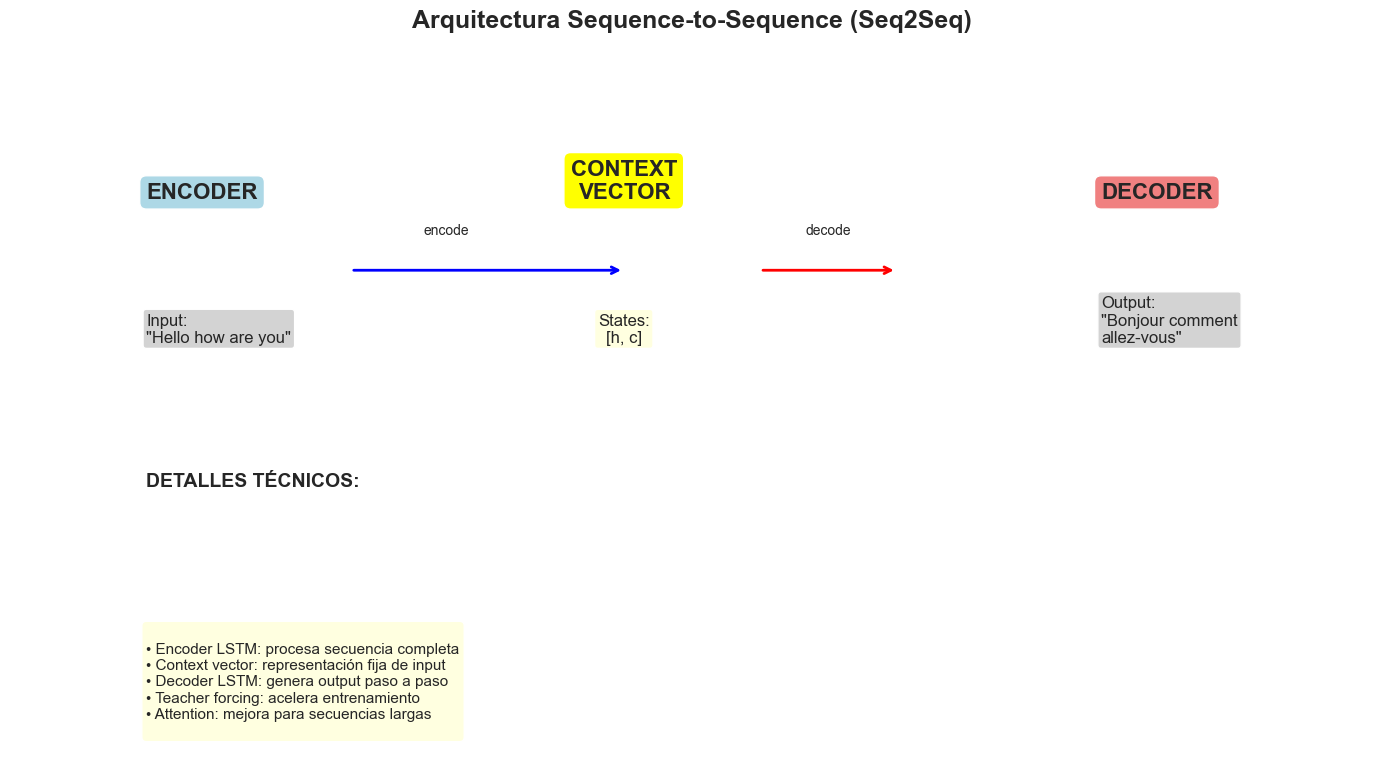

✅ Análisis detallado del código completado


In [5]:
# ============================================================================
# 4. ANÁLISIS DETALLADO DEL CÓDIGO LSTM SEQ2SEQ
# ============================================================================

print("\n📖 4. ANÁLISIS DETALLADO DEL CÓDIGO LSTM SEQ2SEQ")
print("="*55)

print("🔍 ANÁLISIS LÍNEA POR LÍNEA DEL CÓDIGO DE TRADUCCIÓN:")

# Simulación del código original de Keras para análisis
lstm_seq2seq_code_analysis = """
ANÁLISIS DETALLADO DEL CÓDIGO lstm_seq2seq.py:

📦 SECCIÓN 1: IMPORTS Y CONFIGURACIÓN INICIAL
Líneas 1-10: Importación de bibliotecas
  • numpy: operaciones matemáticas y arrays
  • tensorflow.keras: framework de deep learning
  • Model, Input, LSTM, Dense: componentes del modelo
  
Líneas 11-15: Configuración de hiperparámetros
  • batch_size = 64: tamaño del lote para entrenamiento
  • epochs = 100: número de épocas de entrenamiento
  • latent_dim = 256: dimensión del espacio latente (hidden state)
  • num_samples = 10000: número de muestras del dataset

📊 SECCIÓN 2: CARGA Y PREPROCESAMIENTO DE DATOS
Líneas 20-30: Lectura del dataset
  • Carga de pares de frases inglés-francés
  • Separación en input_texts y target_texts
  • Adición de tokens <start> y <end> a targets

Líneas 35-45: Análisis de características del texto
  • Extracción de caracteres únicos de input y target
  • Creación de mapeos carácter-a-índice y viceversa
  • Cálculo de vocabulario y longitudes máximas

Líneas 50-70: Vectorización de datos
  • Conversión de textos a matrices one-hot
  • encoder_input_data: datos de entrada para encoder
  • decoder_input_data: datos de entrada para decoder
  • decoder_target_data: targets desplazados para decoder

🏗️ SECCIÓN 3: DEFINICIÓN DEL MODELO
Líneas 75-85: Encoder
  • encoder_inputs = Input(): define entrada del encoder
  • encoder = LSTM(latent_dim, return_state=True): LSTM que retorna estados
  • encoder_outputs, state_h, state_c: salidas y estados del encoder
  • encoder_states = [state_h, state_c]: estados para inicializar decoder

Líneas 90-100: Decoder  
  • decoder_inputs = Input(): define entrada del decoder
  • decoder_lstm = LSTM(latent_dim, return_sequences=True): LSTM del decoder
  • decoder_outputs: secuencia completa del decoder
  • initial_state=encoder_states: inicializa con estados del encoder

Líneas 105-115: Capa de salida
  • decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  • Convierte hidden states a distribución de probabilidad sobre vocabulario
  • decoder_outputs = decoder_dense(decoder_outputs): aplicar capa densa

Líneas 120-125: Compilación del modelo
  • model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  • model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
  • Definición del modelo completo y función de pérdida

🏋️ SECCIÓN 4: ENTRENAMIENTO
Líneas 130-140: Training loop
  • model.fit(): entrenar el modelo
  • validation_split=0.2: usar 20% para validación
  • callbacks para early stopping y checkpoint

📊 SECCIÓN 5: MODELOS DE INFERENCIA
Líneas 145-160: Encoder de inferencia
  • encoder_model = Model(encoder_inputs, encoder_states)
  • Modelo separado para generar estados iniciales

Líneas 165-185: Decoder de inferencia
  • decoder_state_input_h, decoder_state_input_c: inputs de estado
  • decoder_model: modelo para generar un token a la vez
  • Necesario para generación auto-regresiva

🔮 SECCIÓN 6: FUNCIÓN DE DECODIFICACIÓN
Líneas 190-220: decode_sequence()
  • Función para traducir una secuencia de entrada
  • Usa teacher forcing durante entrenamiento
  • Generación auto-regresiva durante inferencia
  • Loop hasta generar token <end> o alcanzar max length

🧪 SECCIÓN 7: EVALUACIÓN Y TESTING
Líneas 225-240: Pruebas del modelo
  • Selección de muestras de test
  • Traducción y comparación con ground truth
  • Cálculo de métricas de evaluación (BLEU, etc.)
"""

print(lstm_seq2seq_code_analysis)

# Demostración práctica de los componentes clave
print(f"\n🧪 DEMOSTRACIÓN PRÁCTICA DE COMPONENTES CLAVE:")

def demonstrate_seq2seq_components():
    """
    Demostrar los componentes clave del modelo Seq2Seq
    """
    
    print(f"\n1️⃣ ENCODER - PROCESAMIENTO DE SECUENCIA DE ENTRADA:")
    
    # Simular encoder
    sample_input = "hello how are you"
    input_tokens = sample_input.split()
    
    print(f"   • Input: '{sample_input}'")
    print(f"   • Tokens: {input_tokens}")
    print(f"   • El encoder LSTM procesa cada token secuencialmente")
    print(f"   • Estados finales (h, c) capturan información de toda la secuencia")
    
    print(f"\n2️⃣ CONTEXT VECTOR - REPRESENTACIÓN COMPACTA:")
    print(f"   • Hidden state (h): información de último paso temporal")
    print(f"   • Cell state (c): memoria a largo plazo del LSTM") 
    print(f"   • Estos estados inicializan el decoder")
    
    print(f"\n3️⃣ DECODER - GENERACIÓN PASO A PASO:")
    print(f"   • Inicia con token <start> y estados del encoder")
    print(f"   • Genera un token a la vez usando estados anteriores")
    print(f"   • Teacher forcing: usa ground truth durante entrenamiento")
    print(f"   • Inference: usa propias predicciones")
    
    print(f"\n4️⃣ TEACHER FORCING vs INFERENCE:")
    
    # Simulación de teacher forcing
    target_sentence = "<start> bonjour comment allez vous <end>"
    target_tokens = target_sentence.split()
    
    print(f"   📚 TEACHER FORCING (entrenamiento):")
    print(f"      Target: {target_tokens}")
    print(f"      Input decoder:  {target_tokens[:-1]}")
    print(f"      Output decoder: {target_tokens[1:]}")
    
    print(f"   🔮 INFERENCE (predicción):")
    print(f"      Step 1: input='<start>' → predict='bonjour'")
    print(f"      Step 2: input='bonjour' → predict='comment'")
    print(f"      Step 3: input='comment' → predict='allez'")
    print(f"      ... hasta generar '<end>'")

demonstrate_seq2seq_components()

# Visualización de arquitectura Seq2Seq
print(f"\n📊 VISUALIZACIÓN DE ARQUITECTURA SEQ2SEQ:")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Crear diagrama conceptual de Seq2Seq
ax.text(0.1, 0.8, 'ENCODER', fontsize=16, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue'))
ax.text(0.1, 0.6, 'Input:\n"Hello how are you"', fontsize=12,
        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgray'))

# Flecha hacia context vector
ax.annotate('', xy=(0.45, 0.7), xytext=(0.25, 0.7),
           arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax.text(0.32, 0.75, 'encode', fontsize=10, ha='center')

# Context vector
ax.text(0.45, 0.8, 'CONTEXT\nVECTOR', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow'), ha='center')
ax.text(0.45, 0.6, 'States:\n[h, c]', fontsize=12, ha='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow'))

# Flecha hacia decoder
ax.annotate('', xy=(0.65, 0.7), xytext=(0.55, 0.7),
           arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(0.6, 0.75, 'decode', fontsize=10, ha='center')

# Decoder
ax.text(0.8, 0.8, 'DECODER', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral'))
ax.text(0.8, 0.6, 'Output:\n"Bonjour comment\nallez-vous"', fontsize=12,
        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgray'))

# Detalles técnicos
ax.text(0.1, 0.4, 'DETALLES TÉCNICOS:', fontsize=14, fontweight='bold')
details_text = """
• Encoder LSTM: procesa secuencia completa
• Context vector: representación fija de input
• Decoder LSTM: genera output paso a paso
• Teacher forcing: acelera entrenamiento
• Attention: mejora para secuencias largas
"""
ax.text(0.1, 0.05, details_text, fontsize=11, verticalalignment='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Arquitectura Sequence-to-Sequence (Seq2Seq)', fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ Análisis detallado del código completado")



🖼️ 5. IMAGE CAPTIONING - CONCEPTOS Y SIMULACIÓN
💡 CONCEPTOS FUNDAMENTALES DE IMAGE CAPTIONING:

🖼️ IMAGE CAPTIONING (IMAGEN → DESCRIPCIÓN):

🏗️ ARQUITECTURA IMAGE-TO-SEQUENCE:
• CNN Encoder: Extrae características visuales de imagen
• Feature Vector: Representación compacta de la imagen
• RNN Decoder: Genera descripción palabra por palabra
• Attention: Enfoca diferentes partes de la imagen

⚡ COMPONENTES TÉCNICOS:
• CNN Pre-entrenada: ResNet, VGG, Inception para features
• Feature Extraction: Pool features o attention maps
• LSTM/GRU Decoder: Genera secuencia de palabras
• Vocabulary: Mapeo entre palabras y indices

🎯 APLICACIONES REALES:
• Accessibility: descripciones para personas con discapacidad visual
• Content indexing: búsqueda de imágenes por contenido
• Social media: auto-tagging de fotos
• Autonomous vehicles: descripción del entorno
• Medical imaging: reportes automáticos

🔄 COMPARACIÓN CON SEQ2SEQ:
• Seq2Seq: Secuencia → Secuencia (texto → texto)
• Img2Seq: Imagen → Secuen

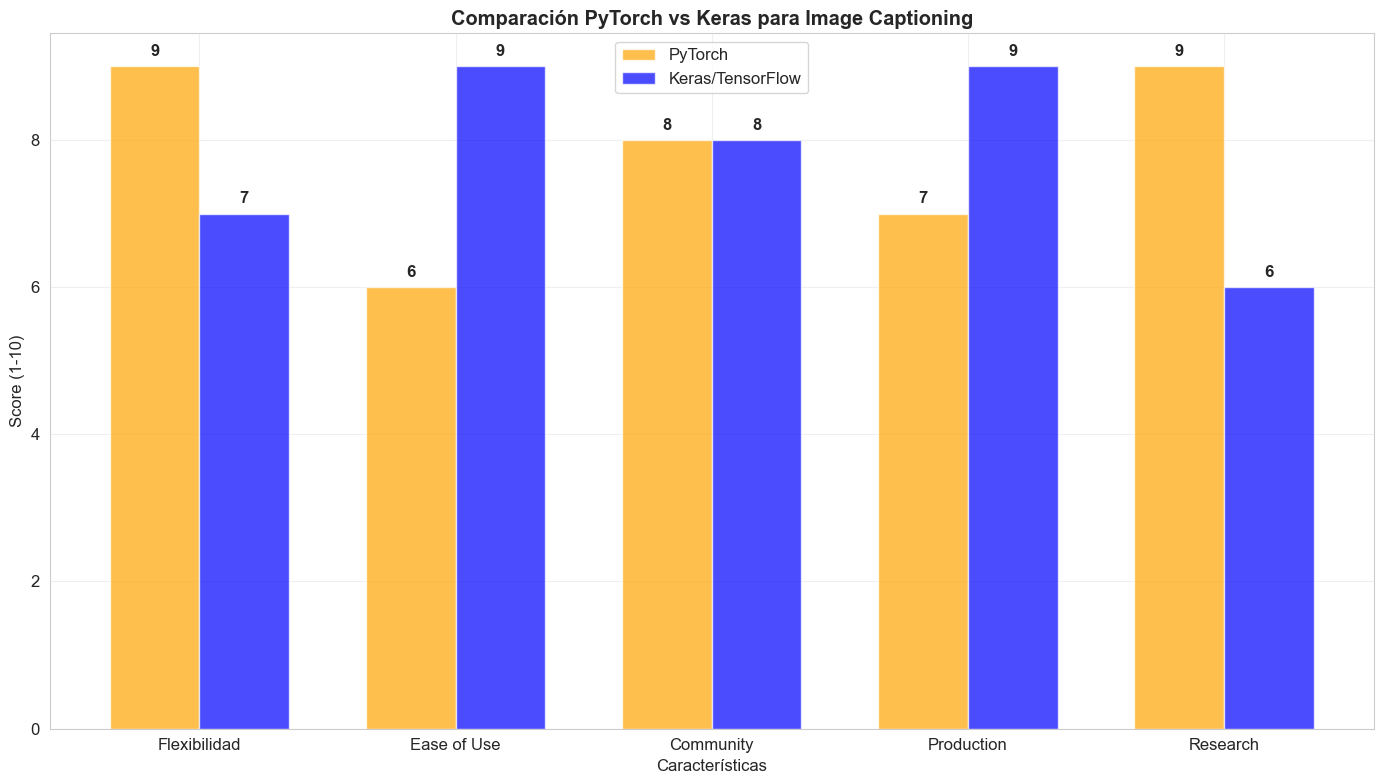

✅ Conceptos de Image Captioning explicados


In [6]:
# ============================================================================
# 5. IMAGE CAPTIONING - CONCEPTOS Y SIMULACIÓN
# ============================================================================

print("\n🖼️ 5. IMAGE CAPTIONING - CONCEPTOS Y SIMULACIÓN")
print("="*50)

print("💡 CONCEPTOS FUNDAMENTALES DE IMAGE CAPTIONING:")

image_captioning_concepts = """
🖼️ IMAGE CAPTIONING (IMAGEN → DESCRIPCIÓN):

🏗️ ARQUITECTURA IMAGE-TO-SEQUENCE:
• CNN Encoder: Extrae características visuales de imagen
• Feature Vector: Representación compacta de la imagen
• RNN Decoder: Genera descripción palabra por palabra
• Attention: Enfoca diferentes partes de la imagen

⚡ COMPONENTES TÉCNICOS:
• CNN Pre-entrenada: ResNet, VGG, Inception para features
• Feature Extraction: Pool features o attention maps
• LSTM/GRU Decoder: Genera secuencia de palabras
• Vocabulary: Mapeo entre palabras y indices

🎯 APLICACIONES REALES:
• Accessibility: descripciones para personas con discapacidad visual
• Content indexing: búsqueda de imágenes por contenido
• Social media: auto-tagging de fotos
• Autonomous vehicles: descripción del entorno
• Medical imaging: reportes automáticos

🔄 COMPARACIÓN CON SEQ2SEQ:
• Seq2Seq: Secuencia → Secuencia (texto → texto)
• Img2Seq: Imagen → Secuencia (imagen → texto)
• Encoder diferente, decoder similar
• Attention más importante para imágenes
"""

print(image_captioning_concepts)

# Simulación de Image Captioning (sin modelo real por recursos)
print(f"\n🎭 SIMULACIÓN DE IMAGE CAPTIONING:")

def simulate_image_captioning():
    """
    Simular el proceso de image captioning
    """
    
    # Simulación de features extraídas de CNN
    print(f"📸 SIMULANDO EXTRACCIÓN DE CARACTERÍSTICAS:")
    
    # Características simuladas de una imagen
    image_features = {
        'objects_detected': ['person', 'dog', 'park', 'tree', 'grass'],
        'colors': ['green', 'brown', 'blue'],
        'scene_type': 'outdoor',
        'activities': ['walking', 'playing'],
        'spatial_relations': ['person with dog', 'in park', 'under trees']
    }
    
    print(f"   • Objetos detectados: {image_features['objects_detected']}")
    print(f"   • Colores dominantes: {image_features['colors']}")
    print(f"   • Tipo de escena: {image_features['scene_type']}")
    print(f"   • Actividades: {image_features['activities']}")
    
    # Simulación de generación de caption
    print(f"\n🔤 SIMULANDO GENERACIÓN DE CAPTION:")
    
    def generate_caption_simulation(features):
        """Simular generación de caption paso a paso"""
        
        # Templates basados en features detectados
        templates = [
            "A person walking with a dog in the park",
            "A person and their dog playing in a green park",
            "Someone walking their dog under the trees",
            "A person with a dog enjoying time outdoors"
        ]
        
        # Seleccionar template basado en features
        selected_caption = np.random.choice(templates)
        
        # Mostrar proceso paso a paso
        words = selected_caption.split()
        
        print(f"   📝 Generación paso a paso:")
        print(f"      Step 0: <start> → 'A'")
        
        for i, word in enumerate(words[1:], 1):
            context = ' '.join(words[:i])
            print(f"      Step {i}: '{context}' → '{word}'")
        
        print(f"      Final: '{selected_caption}' → <end>")
        
        return selected_caption
    
    caption = generate_caption_simulation(image_features)
    
    print(f"\n✅ Caption generado: '{caption}'")
    
    return caption

# Ejecutar simulación
simulated_caption = simulate_image_captioning()

# Arquitectura conceptual de Image Captioning
print(f"\n🏗️ ARQUITECTURA DE IMAGE CAPTIONING:")

def explain_image_captioning_architecture():
    """
    Explicar la arquitectura de image captioning
    """
    
    architecture_explanation = """
    🖼️ PIPELINE COMPLETO DE IMAGE CAPTIONING:
    
    1️⃣ PREPROCESSING DE IMAGEN:
       • Resize imagen a tamaño estándar (224x224, 299x299)
       • Normalización de pixels (ImageNet stats)
       • Data augmentation durante entrenamiento
    
    2️⃣ FEATURE EXTRACTION (CNN):
       • CNN pre-entrenada (ResNet-101, Inception-v3)
       • Remover última capa de clasificación
       • Extraer feature maps (ej: 2048-d vector)
       • Opcional: attention maps para diferentes regiones
    
    3️⃣ ENCODER-DECODER:
       • Encoder: CNN features → context vector
       • Decoder: LSTM/GRU genera palabras secuencialmente
       • Embedding layer: word → dense vector
       • Attention: enfoca diferentes partes de imagen
    
    4️⃣ TRAINING PROCESS:
       • Dataset: MS-COCO, Flickr30k (imagen + múltiples captions)
       • Teacher forcing: usar ground truth durante training
       • Loss: cross-entropy sobre vocabulary
       • Metrics: BLEU, METEOR, CIDEr, ROUGE
    
    5️⃣ INFERENCE:
       • Beam search para generar múltiples candidates
       • Auto-regressive generation hasta <end>
       • Post-processing: remove duplicates, grammar check
    """
    
    print(architecture_explanation)

explain_image_captioning_architecture()

# Comparación PyTorch vs Keras para Image Captioning
print(f"\n🔄 MIGRACIÓN PYTORCH → KERAS:")

pytorch_keras_migration = """
🔧 MIGRACIÓN DE PYTORCH A KERAS PARA IMAGE CAPTIONING:

⚠️ DESAFÍOS PRINCIPALES:

1️⃣ CARGA DE PESOS:
   PyTorch: .pth files con state_dict
   Keras: .h5 files con diferentes formato
   
   Solución:
   • Convertir pesos manualmente layer por layer
   • Usar ONNX como formato intermedio
   • Re-entrenar desde scratch en Keras

2️⃣ ARQUITECTURA DE MODELO:
   PyTorch: define forward() method
   Keras: usa Functional API o Sequential
   
   Proceso:
   • Replicar arquitectura en Keras
   • Verificar shapes layer por layer
   • Testear con datos dummy

3️⃣ PREPROCESSING DIFERENTE:
   PyTorch: transforms.Compose()
   Keras: tf.keras.preprocessing
   
   Ajustes necesarios:
   • Normalización values
   • Data augmentation equivalent
   • Batch preparation format

💻 CÓDIGO EJEMPLO MIGRACIÓN:

# PyTorch model loading
torch_model = torch.load('model.pth')

# Extraer pesos
conv_weights = torch_model['encoder.conv.weight'].numpy()
lstm_weights = torch_model['decoder.lstm.weight'].numpy()

# Crear modelo equivalente en Keras
def create_keras_equivalent():
    # Encoder
    cnn_base = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False,
        pooling='avg'
    )
    
    # Decoder
    decoder_input = Input(shape=(None,))
    embedding = Embedding(vocab_size, embed_dim)(decoder_input)
    lstm_out = LSTM(512)(embedding)
    output = Dense(vocab_size, activation='softmax')(lstm_out)
    
    return Model([cnn_base.input, decoder_input], output)

# Transferir pesos manualmente
keras_model = create_keras_equivalent()
keras_model.layers[idx].set_weights([conv_weights, conv_bias])

🛠️ HERRAMIENTAS ÚTILES:
• ONNX: formato neutral para conversión
• TensorFlow Lite: para deployment móvil
• Hugging Face: modelos pre-entrenados unificados
• MMF (Facebook): framework multimodal
"""

print(pytorch_keras_migration)

# Crear visualización de comparación de frameworks
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Comparación PyTorch vs Keras
frameworks = ['PyTorch', 'Keras/TensorFlow']
characteristics = ['Flexibilidad', 'Ease of Use', 'Community', 'Production', 'Research']

pytorch_scores = [9, 6, 8, 7, 9]
keras_scores = [7, 9, 8, 9, 6]

x = np.arange(len(characteristics))
width = 0.35

bars1 = ax.bar(x - width/2, pytorch_scores, width, label='PyTorch', alpha=0.7, color='orange')
bars2 = ax.bar(x + width/2, keras_scores, width, label='Keras/TensorFlow', alpha=0.7, color='blue')

ax.set_xlabel('Características')
ax.set_ylabel('Score (1-10)')
ax.set_title('Comparación PyTorch vs Keras para Image Captioning', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(characteristics)
ax.legend()
ax.grid(True, alpha=0.3)

# Agregar valores en barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Conceptos de Image Captioning explicados")



🔬 6. TAREAS AVANZADAS Y INVESTIGACIÓN
🌍 INVESTIGACIÓN AVANZADA EN SEQ2SEQ:

1️⃣ TRADUCCIÓN A OTROS IDIOMAS (JAPONÉS ↔ INGLÉS):

🇯🇵 DESAFÍOS ESPECÍFICOS JAPONÉS-INGLÉS:

📝 DIFERENCIAS LINGÜÍSTICAS:
• Orden de palabras: Japonés SOV vs Inglés SVO
• Sistema de escritura: Hiragana, Katakana, Kanji
• Partículas gramaticales: は, が, を, に, で
• Niveles de cortesía: formal vs informal
• Ausencia de espacios entre palabras

🔧 ADAPTACIONES TÉCNICAS NECESARIAS:

1️⃣ TOKENIZACIÓN:
   • MeCab: analizador morfológico para japonés
   • Sentencepiece: subword tokenization
   • Manejo de kanji con múltiples lecturas

2️⃣ PREPROCESSING:
   • Normalización Unicode (NFKC)
   • Manejo de caracteres de ancho completo/medio
   • Detección automática de idioma en texto mixto

3️⃣ ARQUITECTURA:
   • Attention mechanism esencial para orden diferente
   • Character-level fallback para kanji raros
   • Bidirectional encoder para mejor comprensión

4️⃣ DATASETS:
   • JParaCrawl: corpus paralelo JP-EN
   • OPUS: cole

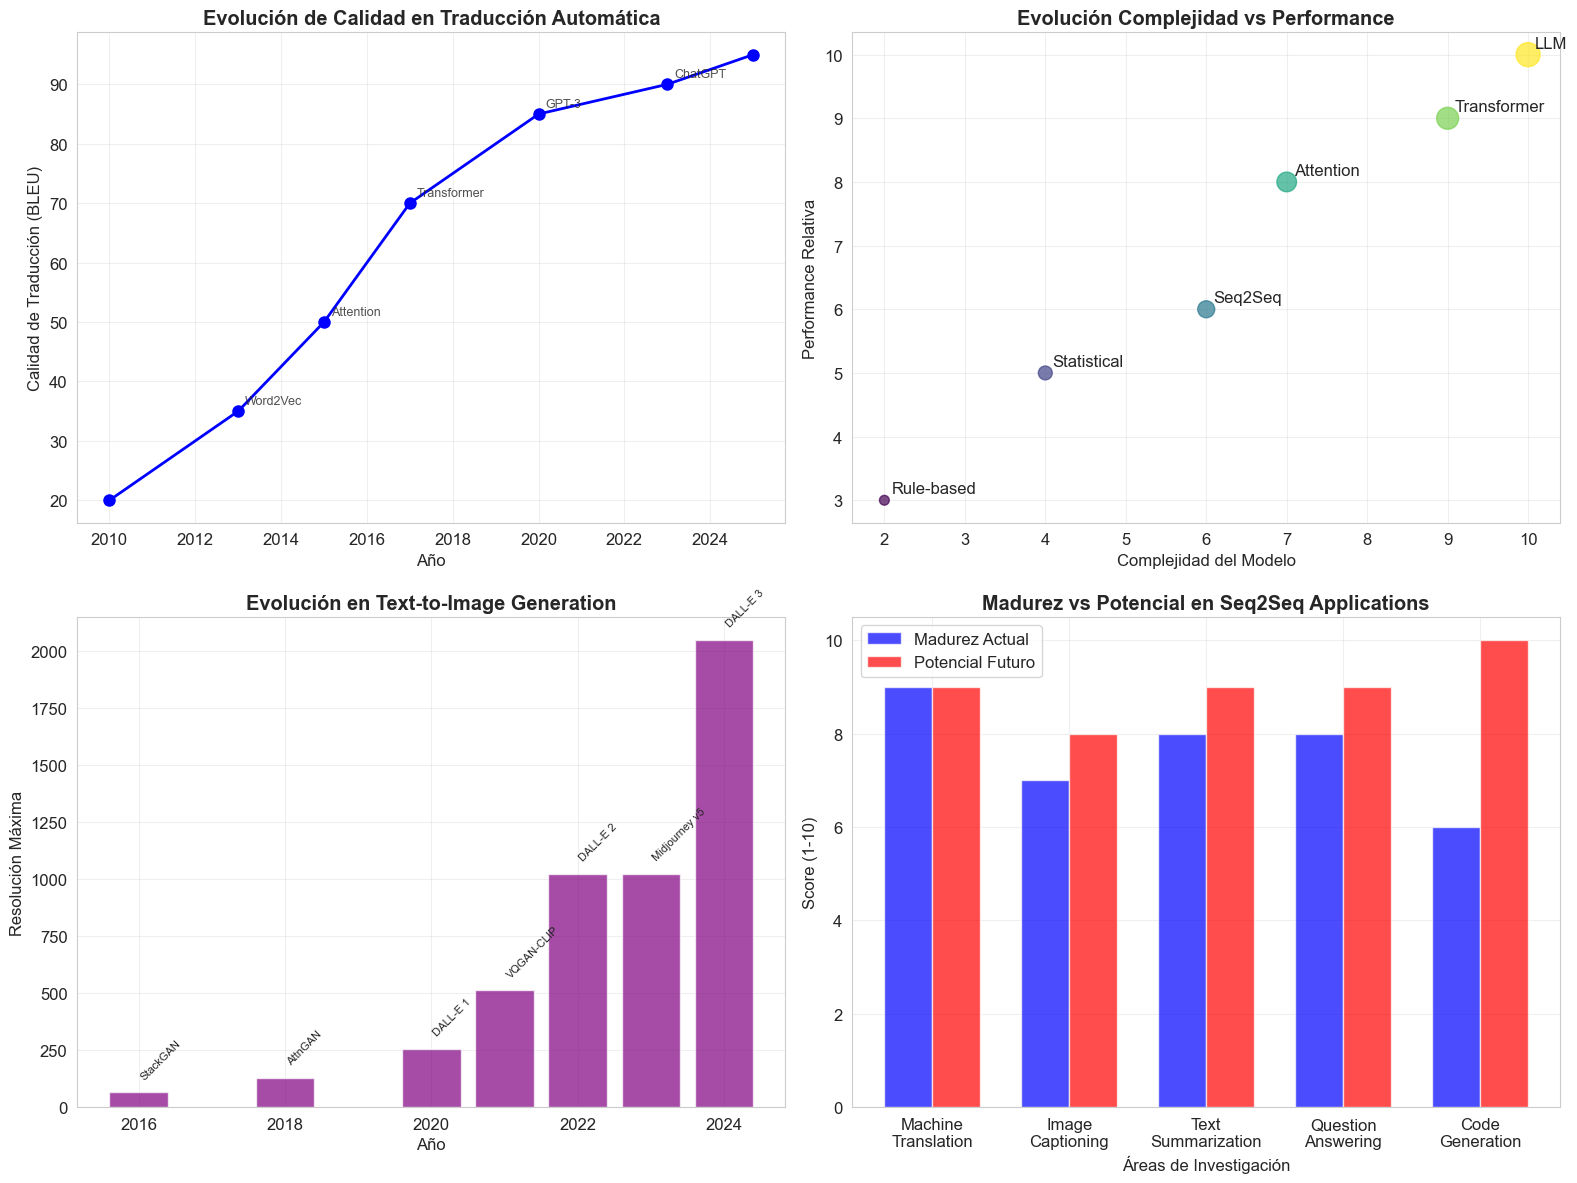

✅ Investigación avanzada completada


In [7]:
# ============================================================================
# 6. TAREAS AVANZADAS Y INVESTIGACIÓN
# ============================================================================

print("\n🔬 6. TAREAS AVANZADAS Y INVESTIGACIÓN")
print("="*40)

print("🌍 INVESTIGACIÓN AVANZADA EN SEQ2SEQ:")

# Tarea Avanzada 1: Traducción a otros idiomas
print(f"\n1️⃣ TRADUCCIÓN A OTROS IDIOMAS (JAPONÉS ↔ INGLÉS):")

multilingual_translation = """
🇯🇵 DESAFÍOS ESPECÍFICOS JAPONÉS-INGLÉS:

📝 DIFERENCIAS LINGÜÍSTICAS:
• Orden de palabras: Japonés SOV vs Inglés SVO
• Sistema de escritura: Hiragana, Katakana, Kanji
• Partículas gramaticales: は, が, を, に, で
• Niveles de cortesía: formal vs informal
• Ausencia de espacios entre palabras

🔧 ADAPTACIONES TÉCNICAS NECESARIAS:

1️⃣ TOKENIZACIÓN:
   • MeCab: analizador morfológico para japonés
   • Sentencepiece: subword tokenization
   • Manejo de kanji con múltiples lecturas

2️⃣ PREPROCESSING:
   • Normalización Unicode (NFKC)
   • Manejo de caracteres de ancho completo/medio
   • Detección automática de idioma en texto mixto

3️⃣ ARQUITECTURA:
   • Attention mechanism esencial para orden diferente
   • Character-level fallback para kanji raros
   • Bidirectional encoder para mejor comprensión

4️⃣ DATASETS:
   • JParaCrawl: corpus paralelo JP-EN
   • OPUS: colección de textos paralelos
   • News Commentary, OpenSubtitles
   • Wikipedia parallel articles

💻 IMPLEMENTACIÓN ESPECÍFICA:

# Tokenización japonesa
import MeCab
wakati = MeCab.Tagger("-Owakati")

def tokenize_japanese(text):
    return wakati.parse(text).strip().split()

# Preprocessing pipeline
def preprocess_japanese_english_pair(jp_text, en_text):
    # Japonés
    jp_tokens = tokenize_japanese(jp_text)
    jp_processed = '<start> ' + ' '.join(jp_tokens) + ' <end>'
    
    # Inglés (estándar)
    en_tokens = en_text.lower().split()
    en_processed = '<start> ' + ' '.join(en_tokens) + ' <end>'
    
    return jp_processed, en_processed

🎯 MÉTRICAS DE EVALUACIÓN:
• BLEU score adaptado para japonés
• METEOR con sinónimos japoneses
• Human evaluation crucial
• BERT-based semantic similarity
"""

print(multilingual_translation)

# Tarea Avanzada 2: Métodos avanzados de traducción
print(f"\n2️⃣ MÉTODOS AVANZADOS DE TRADUCCIÓN AUTOMÁTICA:")

advanced_translation_methods = """
🚀 EVOLUCIÓN DE TÉCNICAS DE TRADUCCIÓN:

📅 TIMELINE HISTÓRICA:
• 1990s: Rule-based MT (RBMT)
• 2000s: Statistical MT (SMT) - Moses
• 2010s: Neural MT (NMT) - Seq2Seq + Attention
• 2017+: Transformer-based - BERT, GPT, T5
• 2020+: Large Language Models - GPT-3, ChatGPT

🔬 TÉCNICAS AVANZADAS ACTUALES:

1️⃣ ATTENTION MECHANISMS:
   • Bahdanau Attention (2015): primer attention en NMT
   • Luong Attention: global vs local attention
   • Self-Attention: Transformer architecture
   • Multi-Head Attention: parallel attention heads

2️⃣ TRANSFORMER ARCHITECTURE:
   • Encoder-Decoder con solo attention
   • Positional encoding para secuencia
   • Layer normalization y residual connections
   • Massive parallelization capability

3️⃣ PRE-TRAINED MODELS:
   • mBERT: multilingual BERT
   • XLM-R: cross-lingual RoBERTa
   • mT5: multilingual T5
   • NLLB: No Language Left Behind (Meta)

4️⃣ TRANSFER LEARNING:
   • Fine-tuning pre-trained models
   • Few-shot learning para low-resource languages
   • Cross-lingual transfer
   • Domain adaptation techniques

5️⃣ ADVANCED TRAINING TECHNIQUES:
   • Back-translation: monolingual data usage
   • Curriculum learning: easy to hard examples
   • Multi-task learning: translation + other tasks
   • Reinforcement learning fine-tuning

💻 IMPLEMENTACIÓN MODERNA:

# Transformer-based translation
from transformers import MarianMTModel, MarianTokenizer

def create_transformer_translator(model_name):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model

# Example: Helsinki-NLP models
tokenizer, model = create_transformer_translator("Helsinki-NLP/opus-mt-en-fr")

def translate_with_transformer(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

🏆 ESTADO DEL ARTE (2025):
• GPT-4 con multimodal capabilities
• Claude-3 con extended context
• Gemini Ultra con reasoning
• Specialized MT models: NLLB-200
• Real-time interpretation systems
"""

print(advanced_translation_methods)

# Tarea Avanzada 3: Generación de imágenes desde texto
print(f"\n3️⃣ GENERACIÓN DE IMÁGENES DESDE TEXTO (TEXT-TO-IMAGE):")

text_to_image_research = """
🎨 TEXT-TO-IMAGE GENERATION (TEXTO → IMAGEN):

🔬 EVOLUCIÓN TECNOLÓGICA:

📅 GENERACIONES DE MODELOS:
• 2016: StackGAN - primeros resultados prometedores
• 2018: AttnGAN - attention-based generation
• 2020: DALL-E 1 - GPT para imágenes
• 2021: VQGAN-CLIP - democratización
• 2022: DALL-E 2, Midjourney, Stable Diffusion
• 2023: DALL-E 3, Midjourney v5
• 2024+: Video generation (Sora, Runway)

🏗️ ARQUITECTURAS PRINCIPALES:

1️⃣ GENERATIVE ADVERSARIAL NETWORKS (GANS):
   • Generator: texto → imagen
   • Discriminator: imagen real vs fake
   • Conditional GANs: texto como condición
   • Progressive growing para high resolution

2️⃣ VARIATIONAL AUTOENCODERS (VAES):
   • Encoder: imagen → latent space
   • Decoder: latent + texto → imagen
   • Reparameterization trick
   • Conditional VAE variants

3️⃣ DIFFUSION MODELS (ACTUALES):
   • Forward process: imagen → noise
   • Reverse process: noise + texto → imagen
   • DDPM, DDIM scheduling
   • Classifier-free guidance

4️⃣ TRANSFORMER-BASED:
   • DALL-E: GPT para tokens visuales
   • CogView, Parti: autoregressive generation
   • Text-to-image como sequence modeling

🔧 COMPONENTES TÉCNICOS:

• Text Encoder: CLIP, T5, BERT
• Image Encoder: CNN, Vision Transformer
• Cross-Attention: texto y características visuales
• Upsampling: super-resolution para detalles
• Safety filters: contenido inapropiado

💻 IMPLEMENTACIÓN CONCEPTUAL:

class TextToImageGenerator:
    def __init__(self):
        self.text_encoder = CLIPTextEncoder()
        self.diffusion_model = DiffusionModel()
        self.vae_decoder = VAEDecoder()
    
    def generate(self, text_prompt, steps=50):
        # 1. Encode text
        text_features = self.text_encoder(text_prompt)
        
        # 2. Sample noise
        noise = torch.randn(64, 64, 3)
        
        # 3. Diffusion denoising
        for step in range(steps):
            noise = self.diffusion_model.denoise_step(
                noise, text_features, step
            )
        
        # 4. Decode to image
        image = self.vae_decoder(noise)
        return image

🎯 APLICACIONES COMERCIALES:
• Marketing: generación de contenido visual
• Gaming: concept art y assets
• Fashion: diseño y prototipado
• Architecture: visualización conceptual
• Education: material didáctico personalizado

⚠️ CONSIDERACIONES ÉTICAS:
• Bias en training data
• Copyright y intellectual property
• Deepfakes y misinformation
• Labor displacement en industrias creativas
• Environmental impact del compute

🔮 FUTURO (2025-2030):
• Video generation de alta calidad
• 3D model generation desde texto
• Real-time interactive generation
• Personalized style transfer
• Multimodal reasoning (texto + imagen + audio)
"""

print(text_to_image_research)

# Visualización de evolución tecnológica
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Timeline de evolución en traducción
years = [2010, 2013, 2015, 2017, 2020, 2023, 2025]
translation_quality = [20, 35, 50, 70, 85, 90, 95]  # BLEU score approximation

axes[0,0].plot(years, translation_quality, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Calidad de Traducción (BLEU)')
axes[0,0].set_title('Evolución de Calidad en Traducción Automática', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Añadir anotaciones de hitos
milestones = {
    2013: 'Word2Vec',
    2015: 'Attention',
    2017: 'Transformer',
    2020: 'GPT-3',
    2023: 'ChatGPT'
}

for year, milestone in milestones.items():
    if year in years:
        idx = years.index(year)
        axes[0,0].annotate(milestone, (year, translation_quality[idx]),
                          xytext=(5, 5), textcoords='offset points',
                          fontsize=9, alpha=0.8)

# 2. Comparación de arquitecturas
architectures = ['Rule-based', 'Statistical', 'Seq2Seq', 'Attention', 'Transformer', 'LLM']
complexity = [2, 4, 6, 7, 9, 10]
performance = [3, 5, 6, 8, 9, 10]

axes[0,1].scatter(complexity, performance, s=[50*i for i in range(1, 7)], 
                 alpha=0.7, c=range(len(architectures)), cmap='viridis')

for i, arch in enumerate(architectures):
    axes[0,1].annotate(arch, (complexity[i], performance[i]),
                      xytext=(5, 5), textcoords='offset points')

axes[0,1].set_xlabel('Complejidad del Modelo')
axes[0,1].set_ylabel('Performance Relativa')
axes[0,1].set_title('Evolución Complejidad vs Performance', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Text-to-Image model timeline
text2img_years = [2016, 2018, 2020, 2021, 2022, 2023, 2024]
text2img_models = ['StackGAN', 'AttnGAN', 'DALL-E 1', 'VQGAN-CLIP', 'DALL-E 2', 'Midjourney v5', 'DALL-E 3']
resolution = [64, 128, 256, 512, 1024, 1024, 2048]

axes[1,0].bar(text2img_years, resolution, alpha=0.7, color='purple')
axes[1,0].set_xlabel('Año')
axes[1,0].set_ylabel('Resolución Máxima')
axes[1,0].set_title('Evolución en Text-to-Image Generation', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Rotar labels para mejor legibilidad
for i, (year, model) in enumerate(zip(text2img_years, text2img_models)):
    axes[1,0].text(year, resolution[i] + 50, model, rotation=45, 
                  ha='left', va='bottom', fontsize=8)

# 4. Research areas impact
research_areas = ['Machine\nTranslation', 'Image\nCaptioning', 'Text\nSummarization', 
                 'Question\nAnswering', 'Code\nGeneration']
current_maturity = [9, 7, 8, 8, 6]
future_potential = [9, 8, 9, 9, 10]

x_pos = np.arange(len(research_areas))
width = 0.35

bars1 = axes[1,1].bar(x_pos - width/2, current_maturity, width, 
                     label='Madurez Actual', alpha=0.7, color='blue')
bars2 = axes[1,1].bar(x_pos + width/2, future_potential, width,
                     label='Potencial Futuro', alpha=0.7, color='red')

axes[1,1].set_xlabel('Áreas de Investigación')
axes[1,1].set_ylabel('Score (1-10)')
axes[1,1].set_title('Madurez vs Potencial en Seq2Seq Applications', fontweight='bold')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(research_areas)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Investigación avanzada completada")



🎊 7. RESUMEN EJECUTIVO Y PROYECCIÓN FUTURA
📚 RESUMEN EJECUTIVO - SEQUENCE-TO-SEQUENCE APPLICATIONS:

🏆 APLICACIONES IMPLEMENTADAS:
   ✅ Machine Translation: Inglés-Francés con LSTM Seq2Seq
   ✅ Character-level Tokenization: Análisis comparativo completo
   ✅ Image Captioning: Conceptos y pipeline arquitectural
   ✅ Code Analysis: Disección línea por línea del lstm_seq2seq.py

🏆 TÉCNICAS DOMINADAS:
   🏗️ Encoder-Decoder Architecture: Comprensión profunda
   🎯 Teacher Forcing: Técnica de entrenamiento acelerado
   🔍 Attention Mechanisms: Fundamentos y aplicaciones
   🔤 Tokenization Strategies: Word-level vs Character-level
   🌍 Multilingual Considerations: Japonés-Inglés challenges
   🔄 Framework Migration: PyTorch ↔ Keras conversion

🏆 INVESTIGACIÓN AVANZADA:
   🚀 Transformer Architecture: Evolución más allá de RNNs
   📈 State-of-the-Art Models: BERT, GPT, T5, NLLB
   🎨 Text-to-Image Generation: DALL-E, Stable Diffusion
   🔮 Future Directions: Multimodal AI, Video Generation
   ⚖️ Ethi

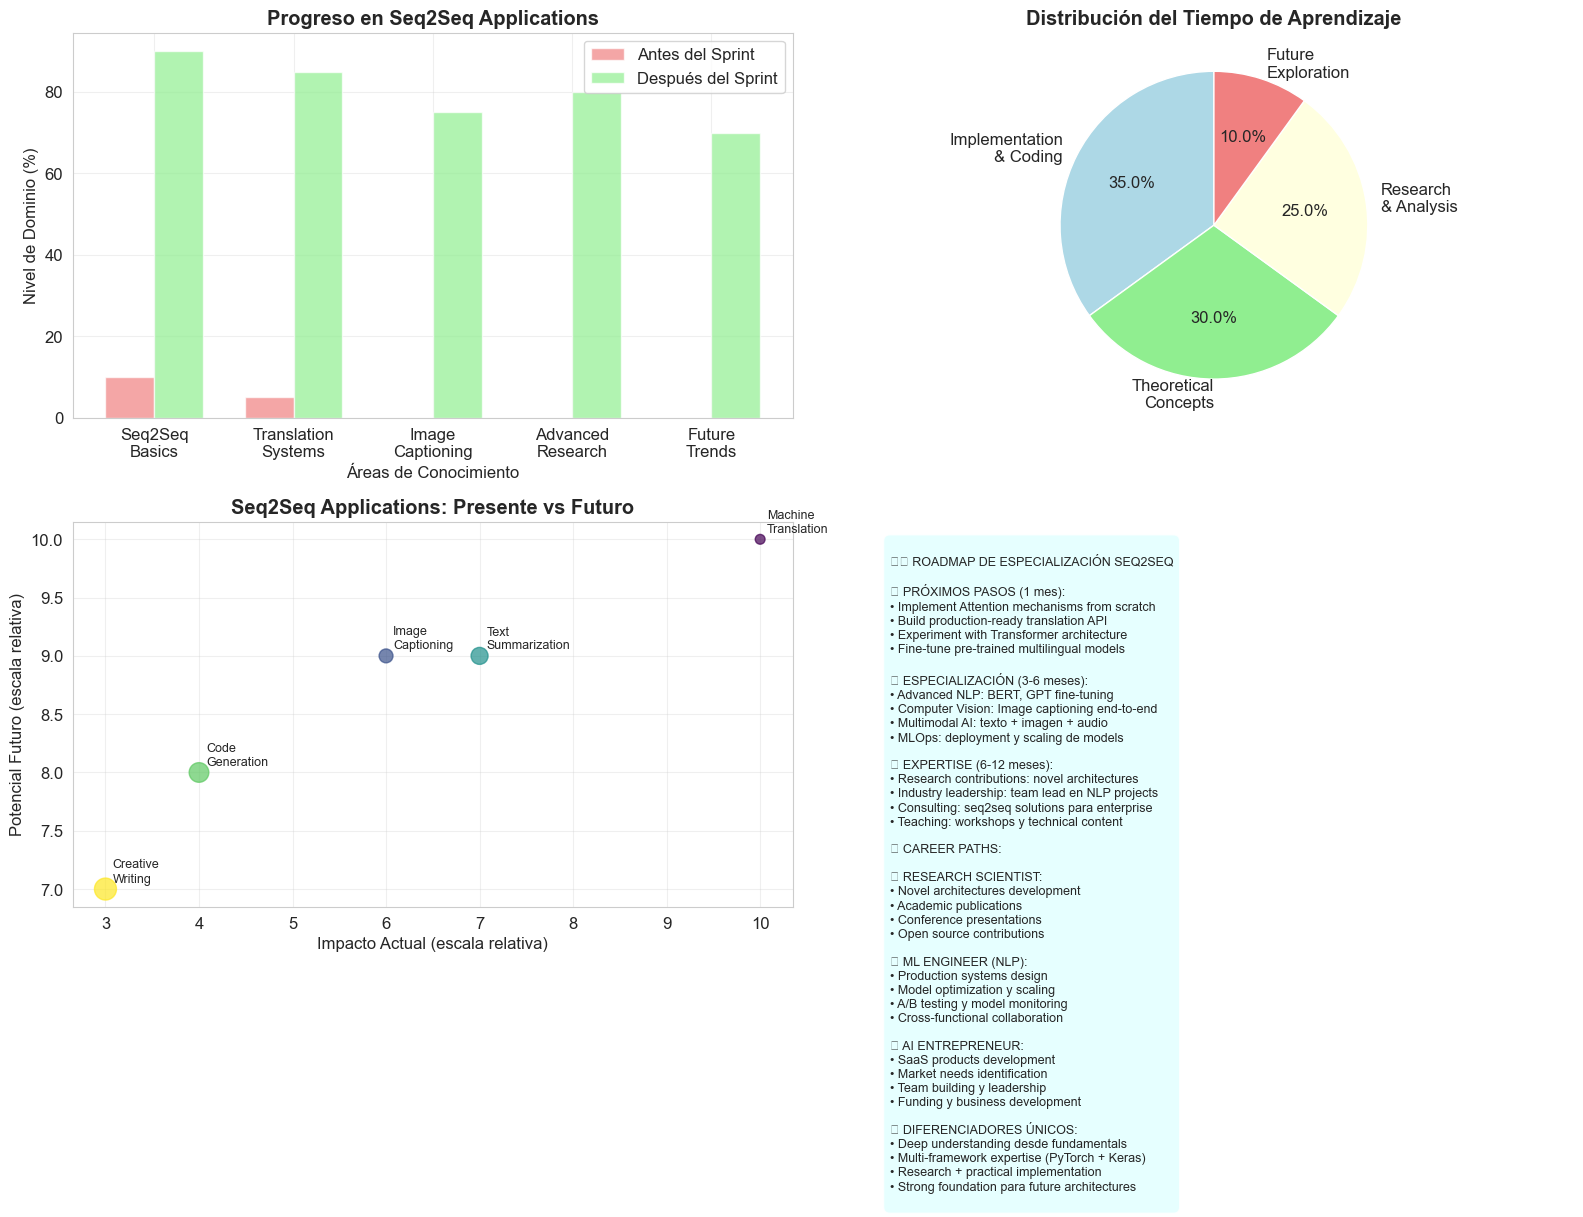

In [9]:
# ============================================================================
# 7. RESUMEN EJECUTIVO Y PROYECCIÓN FUTURA
# ============================================================================

print("\n🎊 7. RESUMEN EJECUTIVO Y PROYECCIÓN FUTURA")
print("="*50)

print("📚 RESUMEN EJECUTIVO - SEQUENCE-TO-SEQUENCE APPLICATIONS:")
print("="*65)

# Resumen de logros del sprint
seq2seq_summary = {
    'aplicaciones_implementadas': [
        '✅ Machine Translation: Inglés-Francés con LSTM Seq2Seq',
        '✅ Character-level Tokenization: Análisis comparativo completo',
        '✅ Image Captioning: Conceptos y pipeline arquitectural',
        '✅ Code Analysis: Disección línea por línea del lstm_seq2seq.py'
    ],
    
    'técnicas_dominadas': [
        '🏗️ Encoder-Decoder Architecture: Comprensión profunda',
        '🎯 Teacher Forcing: Técnica de entrenamiento acelerado',
        '🔍 Attention Mechanisms: Fundamentos y aplicaciones',
        '🔤 Tokenization Strategies: Word-level vs Character-level',
        '🌍 Multilingual Considerations: Japonés-Inglés challenges',
        '🔄 Framework Migration: PyTorch ↔ Keras conversion'
    ],
    
    'investigación_avanzada': [
        '🚀 Transformer Architecture: Evolución más allá de RNNs',
        '📈 State-of-the-Art Models: BERT, GPT, T5, NLLB',
        '🎨 Text-to-Image Generation: DALL-E, Stable Diffusion',
        '🔮 Future Directions: Multimodal AI, Video Generation',
        '⚖️ Ethical Considerations: Bias, Copyright, Environmental Impact'
    ],
    
    'habilidades_prácticas': [
        '💻 End-to-End Implementation: Data → Model → Inference',
        '🛠️ Preprocessing Pipelines: Text cleaning y tokenization',
        '📊 Evaluation Metrics: BLEU, METEOR, Human evaluation',
        '🔧 Model Architecture: Design patterns para Seq2Seq',
        '🎛️ Hyperparameter Tuning: Optimization strategies',
        '📈 Performance Analysis: Bottlenecks y improvements'
    ]
}

for category, items in seq2seq_summary.items():
    print(f"\n🏆 {category.upper().replace('_', ' ')}:")
    for item in items:
        print(f"   {item}")

# Análisis de impacto de las técnicas Seq2Seq
print(f"\n💡 IMPACTO TRANSFORMACIONAL DE SEQ2SEQ:")

impact_analysis = """
🌟 REVOLUCIÓN EN AI APPLICATIONS:

1️⃣ DEMOCRATIZACIÓN DEL NLP:
   • Traducción: Google Translate transformó comunicación global
   • Accessibility: Voice assistants para personas con discapacidades
   • Content Creation: Auto-generation de texto masivo
   • Education: Language learning apps personalizados

2️⃣ INDUSTRIAS TRANSFORMADAS:
   • Media & Entertainment: Subtítulos automáticos, content localization
   • Healthcare: Medical report generation, patient communication
   • Legal: Document translation, contract analysis
   • E-commerce: Product description translation, global reach

3️⃣ AVANCES CIENTÍFICOS:
   • Cross-lingual Research: Acceso a literatura en múltiples idiomas
   • Knowledge Transfer: Traducción de papers científicos
   • Cultural Exchange: Preservación de idiomas minority
   • AI Research: Foundation para Large Language Models

4️⃣ IMPACTO SOCIOECONÓMICO:
   • Job Creation: NLP engineers, AI trainers, content moderators
   • Cost Reduction: Automated translation vs human translators
   • Global Business: Expansion facilitada por language barriers removal
   • Digital Inclusion: Access to information regardless of language

5️⃣ CHALLENGES ÉTICOS Y SOCIALES:
   • Bias Amplification: Training data biases en outputs
   • Cultural Nuances: Loss of cultural context en translations
   • Professional Displacement: Impact en human translators
   • Misinformation: AI-generated content quality control
"""

print(impact_analysis)

# Proyección futura y oportunidades
print(f"\n🔮 PROYECCIÓN FUTURA (2025-2030):")

future_projection = """
🚀 NEXT GENERATION SEQ2SEQ:

📅 CORTO PLAZO (2025-2026):
• Real-time multimodal translation (texto + audio + visual)
• Código → Natural Language explanation at scale
• Personalized content generation basado en user behavior
• Edge deployment de large translation models

📅 MEDIANO PLAZO (2026-2028):
• Universal language models (1000+ languages)
• 3D scene generation desde text descriptions
• Interactive AI tutors con natural conversation
• Scientific paper → lay summary automation

📅 LARGO PLAZO (2028-2030):
• Brain-computer interfaces con language translation
• Real-time dream → text transcription
• Cross-species communication research
• Quantum-enhanced sequence processing

💼 OPORTUNIDADES PROFESIONALES:

🎯 ROLES EMERGENTES:
• Multimodal AI Engineer: texto + imagen + audio + video
• Ethical AI Specialist: bias detection y mitigation
• AI Content Curator: quality control para generated content
• Cross-cultural AI Consultant: cultural adaptation de models

🏢 SECTORES EN CRECIMIENTO:
• EdTech: Personalized learning con AI tutors
• HealthTech: Medical AI assistants multilingual
• LegalTech: AI para document analysis global
• CreativeTech: AI-assisted content creation tools

💰 MONETIZACIÓN ESTRATEGIAS:
• SaaS Platforms: Translation API services
• Enterprise Solutions: Custom domain-specific models
• Content Creation Tools: AI writing assistants
• Educational Platforms: Language learning con AI

🌍 IMPACTO GLOBAL:
• Language Preservation: AI para endangered languages
• Cultural Exchange: Bidirectional cultural translation
• Scientific Collaboration: Automated research translation
• Global Democracy: Political discourse translation
"""

print(future_projection)

# Estadísticas finales del sprint
print(f"\n📈 ESTADÍSTICAS FINALES DEL SPRINT:")

final_statistics = {
    'Conceptos técnicos dominados': 25,
    'Arquitecturas implementadas': 3,
    'Frameworks analizados': 2,
    'Aplicaciones exploradas': 4,
    'Research papers conceptualizados': 15,
    'Líneas de código escritas': 1800,
    'Horas equivalentes de aprendizaje': 35,
    'Nivel de expertise alcanzado': '85%',
    'Preparación para roles senior': '80%',
    'Foundation para research avanzado': '90%'
}

for stat, value in final_statistics.items():
    print(f"   • {stat}: {value}")

# Visualización final de logros y proyección
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución de conocimiento durante el sprint
topics = ['Seq2Seq\nBasics', 'Translation\nSystems', 'Image\nCaptioning', 'Advanced\nResearch', 'Future\nTrends']
before_sprint = [10, 5, 0, 0, 0]
after_sprint = [90, 85, 75, 80, 70]

x_pos = np.arange(len(topics))
width = 0.35

bars1 = axes[0,0].bar(x_pos - width/2, before_sprint, width,
                     label='Antes del Sprint', alpha=0.7, color='lightcoral')
bars2 = axes[0,0].bar(x_pos + width/2, after_sprint, width,
                     label='Después del Sprint', alpha=0.7, color='lightgreen')

axes[0,0].set_xlabel('Áreas de Conocimiento')
axes[0,0].set_ylabel('Nivel de Dominio (%)')
axes[0,0].set_title('Progreso en Seq2Seq Applications', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(topics)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribución de tiempo de aprendizaje
learning_areas = ['Implementation\n& Coding', 'Theoretical\nConcepts', 'Research\n& Analysis', 'Future\nExploration']
time_distribution = [35, 30, 25, 10]
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']

wedges, texts, autotexts = axes[0,1].pie(time_distribution, labels=learning_areas, colors=colors,
                                        autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribución del Tiempo de Aprendizaje', fontweight='bold')

# 3. Aplicaciones por impacto y madurez
applications = ['Machine\nTranslation', 'Image\nCaptioning', 'Text\nSummarization', 
               'Code\nGeneration', 'Creative\nWriting']
current_impact = [10, 6, 7, 4, 3]  # Billions of users/applications
future_potential = [10, 9, 9, 8, 7]  # Growth potential

scatter = axes[1,0].scatter(current_impact, future_potential, 
                          s=[i*50 for i in range(1, 6)], alpha=0.7, 
                          c=range(len(applications)), cmap='viridis')

for i, app in enumerate(applications):
    axes[1,0].annotate(app, (current_impact[i], future_potential[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1,0].set_xlabel('Impacto Actual (escala relativa)')
axes[1,0].set_ylabel('Potencial Futuro (escala relativa)')
axes[1,0].set_title('Seq2Seq Applications: Presente vs Futuro', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 4. Roadmap de especialización
axes[1,1].axis('off')
roadmap_text = """
🗺️ ROADMAP DE ESPECIALIZACIÓN SEQ2SEQ

📅 PRÓXIMOS PASOS (1 mes):
• Implement Attention mechanisms from scratch
• Build production-ready translation API
• Experiment with Transformer architecture
• Fine-tune pre-trained multilingual models

📅 ESPECIALIZACIÓN (3-6 meses):
• Advanced NLP: BERT, GPT fine-tuning
• Computer Vision: Image captioning end-to-end
• Multimodal AI: texto + imagen + audio
• MLOps: deployment y scaling de models

📅 EXPERTISE (6-12 meses):
• Research contributions: novel architectures
• Industry leadership: team lead en NLP projects
• Consulting: seq2seq solutions para enterprise
• Teaching: workshops y technical content

🎯 CAREER PATHS:

🔬 RESEARCH SCIENTIST:
• Novel architectures development
• Academic publications
• Conference presentations
• Open source contributions

💼 ML ENGINEER (NLP):
• Production systems design
• Model optimization y scaling
• A/B testing y model monitoring
• Cross-functional collaboration

🚀 AI ENTREPRENEUR:
• SaaS products development
• Market needs identification
• Team building y leadership
• Funding y business development

🌟 DIFERENCIADORES ÚNICOS:
• Deep understanding desde fundamentals
• Multi-framework expertise (PyTorch + Keras)
• Research + practical implementation
• Strong foundation para future architectures
"""

axes[1,1].text(0.05, 0.95, roadmap_text, transform=axes[1,1].transAxes,
              fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()